In [ ]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model
from subprocess import check_output
from os import listdir, makedirs
from os.path import join, exists, expanduser

In [ ]:
from keras.applications.vgg16 import VGG16
WEIGHTS_DIR = '../input/vgg16'


In [ ]:
local_weights_file= 'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model= VGG16(input_shape= (150,150,3),
                         include_top= False,
                         weights= None)
pre_trained_model.load_weights(local_weights_file)
for layer in pre_trained_model.layers:
  layer.trainable= False

In [ ]:
pre_trained_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [ ]:
last_layer= pre_trained_model.get_layer('block5_pool')
last_output= last_layer.output                                     

In [ ]:
#from tensorflow.keras.optimizers import RMSprop
x= layers.Flatten()(last_output)
x= layers.Dense(1024, activation= 'relu')(x)
x= layers.Dropout(0.2)(x)
x= layers.Dense(10, activation= 'softmax')(x)
model= Model(pre_trained_model.input,x)
model.compile(optimizer= 'adam',loss= 'sparse_categorical_crossentropy',metrics= ['accuracy'])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt



In [ ]:
!pip install pyunpack
!pip install patool

     |████████████████████████████████| 81kB 5.8MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pyunpack import Archive
Archive('/content/drive/My Drive/Colab Notebooks/CatvsDogs.rar').extractall('/content')

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import os
filenames = os.listdir('/content/train')

categories=[]
for f_name in filenames:
  category = f_name.split('.')[0]
  if category =='dog':
    categories.append(1)
  else:
    categories.append(0)

df = pd.DataFrame({
    'filename':filenames,
    'category':categories
})

In [ ]:
df.head()

,filename,category
0,dog.7707.jpg,1
1,dog.10931.jpg,1
2,cat.10139.jpg,0
3,dog.5699.jpg,1
4,cat.5694.jpg,0


In [ ]:
import tensorflow as tf


In [ ]:
df['category']= df['category'].replace({0: 'cat,',1: 'dog'})
train_df, validation_df= train_test_split(df, test_size=0.2, random_state=42)
train_df= train_df.reset_index(drop= True)
validation_df= validation_df.reset_index(drop=True)
total_train= train_df.shape[0]
total_validate= validation_df.shape[0]

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen= ImageDataGenerator(rescale= 1./255, rotation_range=20, shear_range=0.1, zoom_range=0.1, horizontal_flip=True, width_shift_range=0.1, height_shift_range= 0.1)
test_datagen= ImageDataGenerator(rescale= 1./255)
train_generator= train_datagen.flow_from_dataframe(train_df,'/content/train',x_col= 'filename',y_col= 'category', target_size= (128,128), batch_size= 32, class_mode= 'binary')
validation_generator= test_datagen.flow_from_dataframe(validation_df,'/content/train',x_col= 'filename',y_col= 'category', target_size= (128,128), batch_size= 32, class_mode= 'binary')

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [ ]:
early_stopping= tf.keras.callbacks.EarlyStopping(patience= 5)

In [ ]:
history= model.fit(
     train_generator,
     validation_data= validation_generator,
     epochs= 20,
     steps_per_epoch= 100,
     validation_steps= 50,
     verbose= 2, callbacks= [early_stopping]
 )

Epoch 1/20
100/100 - 25s - loss: 0.7484 - accuracy: 0.7700 - val_loss: 0.2809 - val_accuracy: 0.8806
Epoch 2/20
100/100 - 25s - loss: 0.4409 - accuracy: 0.8163 - val_loss: 0.2557 - val_accuracy: 0.8963
Epoch 3/20
100/100 - 25s - loss: 0.3404 - accuracy: 0.8525 - val_loss: 0.2824 - val_accuracy: 0.8687
Epoch 4/20
100/100 - 25s - loss: 0.3397 - accuracy: 0.8519 - val_loss: 0.2740 - val_accuracy: 0.8775
Epoch 5/20
100/100 - 25s - loss: 0.3109 - accuracy: 0.8656 - val_loss: 0.3028 - val_accuracy: 0.8525
Epoch 6/20
100/100 - 25s - loss: 0.3036 - accuracy: 0.8687 - val_loss: 0.2764 - val_accuracy: 0.8763
Epoch 7/20
100/100 - 25s - loss: 0.3266 - accuracy: 0.8534 - val_loss: 0.2889 - val_accuracy: 0.8719


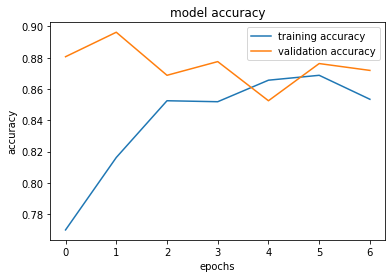

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label= 'training accuracy')
plt.plot(history.history['val_accuracy'], label= 'validation accuracy')
plt.title('model accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()                                                                    
plt.show()

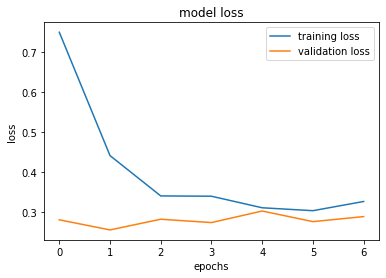

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label= 'training loss')
plt.plot(history.history['val_loss'], label= 'validation loss')
plt.title('model loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()